In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dash import Dash, html, dash_table, dcc, Output, Input
import dash_bootstrap_components as dbc

Import data

In [2]:
pp_db_raw = pd.read_csv("global_power_plant_database.csv", dtype={'other_fuel3': str})
cont = pd.read_csv("list-of-countries-by-continent-2024.csv")

Check columns and merge on country_long and country column

In [3]:

print("Before merge", pp_db_raw.shape)
print("Power Plant DB columns: ", pp_db_raw.columns)
print("Country & Continent CSV file columns: ", cont.columns)
pp_db = pp_db_raw.merge(cont, how='left', left_on='country_long', right_on='country', suffixes=('_short', ''))
print("After merge", pp_db.shape) # 3 columns added and same number of rows due to left join


Before merge (34936, 36)
Power Plant DB columns:  Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018',
       'generation_gwh_2019', 'generation_data_source',
       'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
       'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
       'estimated_generation_gwh_2017', 'estimated_generation_note_2013',
       'estimated_generation_note_2014', 'estimated_generation_note_2015',
       'estimated_generation_note_2016', 'estimated_generation_note_2017'],
      dtype='object')
Country & Continent CSV file columns:  Index(['country', 'continen

Check records missing country field to see if merge was successful

In [4]:

print(pp_db[['country_short', 'country_long', 'country', 'continent']].isna().sum())  
# country column in merged table has 73 missing values, we check which records these correspond to in raw table
print(pp_db_raw[pp_db['country'].isna()]['country_long'].unique())
# Note that 2 power plants are located in Antarctica which we add to Oceania (New Zealand)
print("Antarctica Power Plants: ", pp_db.loc[pp_db['country_long']=='Antarctica', :'primary_fuel'])

country_short     0
country_long      0
country          73
continent        73
dtype: int64
['Antarctica' 'Brunei Darussalam' 'Congo' 'Cote DIvoire'
 'Democratic Republic of the Congo' 'Macedonia' 'Swaziland'
 'Syrian Arab Republic']
Antarctica Power Plants:     country_short country_long                       name   gppd_idnr  \
90           ATA   Antarctica  McMurdo Station Generator  WRI1023843   
91           ATA   Antarctica                Ross Island  WRI1022458   

    capacity_mw  latitude  longitude primary_fuel  
90          6.6  -77.8470   166.6605          Oil  
91          1.0  -77.8428   166.7271         Wind  



Comparing output to list-of-countries-by-continent-2024.csv , we make the following changes manually:

Swaziland --> Eswatini, Brunei Darussalam --> Brunei

Congo --> Republic of the Congo, Cote DIvoire --> Ivory Coast

Democratic Republic of the Congo --> DR Congo, Macedonia --> North Macedonia

Syrian Arab Republic --> Syria

We also  make these changes to the raw data in the continent CSV file:

Add Kosovo, United States --> United States of America

Antarctica --> New Zealand


In [5]:
replacement_dict={
    'Swaziland': 'Eswatini',
    'Brunei Darussalam': 'Brunei',
    'Congo': 'Republic of the Congo',
    'Cote DIvoire': 'Ivory Coast',
    'Democratic Republic of the Congo': 'DR Congo',
    'Macedonia': 'North Macedonia',
    'Syrian Arab Republic': 'Syria',
    'Antarctica': 'New Zealand'
}
pp_db_raw['country_long'] = pp_db_raw['country_long'].replace(replacement_dict)

pp_db = pp_db_raw.merge(cont, how='left', left_on='country_long', right_on='country', suffixes=('_short', ''))

print(pp_db[['country_short', 'country_long', 'country', 'continent']].isna().sum())

country_short    0
country_long     0
country          0
continent        0
dtype: int64


Creating new columns for renewable vs non-renewable energy and 'Other' primary fuel_type by continent and world categories for data visualisation. Aim is that any primary fuel type that represents less than 1% of the output for a continent will be added to an 'Other' category.

In [6]:
print(pp_db['primary_fuel'].unique())
renewable_energies = ['Hydro', 'Solar', 'Wind', 'Biomass', 'Wave and Tidal', 'Geothermal']
non_renewable_energies = ['Nuclear', 'Coal', 'Gas', 'Oil', 'Petcoke',]
other = ['Other', 'Waste', 'Cogeneration', 'Storage']

conditions = [
    pp_db['primary_fuel'].isin(renewable_energies),
    pp_db['primary_fuel'].isin(non_renewable_energies),
    pp_db['primary_fuel'].isin(other)
]

# Define the corresponding categories
choices = ['Renewable', 'Non-Renewable', 'Other']

# Create the new column
pp_db['renew_energy'] = np.select(conditions, choices, default='Unknown')

['Hydro' 'Solar' 'Gas' 'Other' 'Oil' 'Wind' 'Nuclear' 'Coal' 'Waste'
 'Biomass' 'Wave and Tidal' 'Petcoke' 'Geothermal' 'Storage'
 'Cogeneration']


continent
Africa           552.336990
Asia             745.625443
Europe           354.648059
North America    349.916938
Oceania          281.311794
South America    374.340956
Name: capacity_mw, dtype: float64


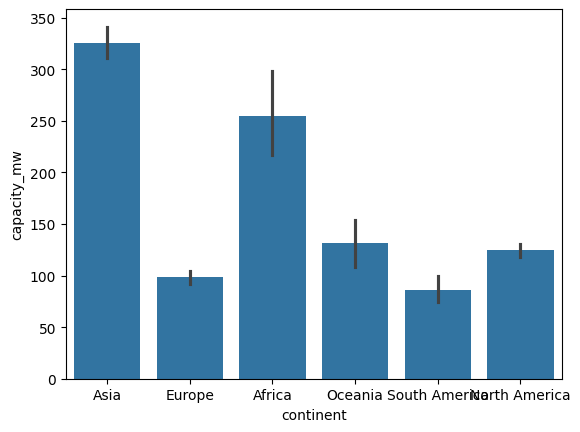

In [7]:
value_vars= ["estimated_generation_gwh_" + str(int(i)) for i in np.linspace(2013, 2017, 5)]
print(pp_db.groupby('continent')['capacity_mw'].std())
sns.barplot(data=pp_db, x='continent', y='capacity_mw')
plt.show()

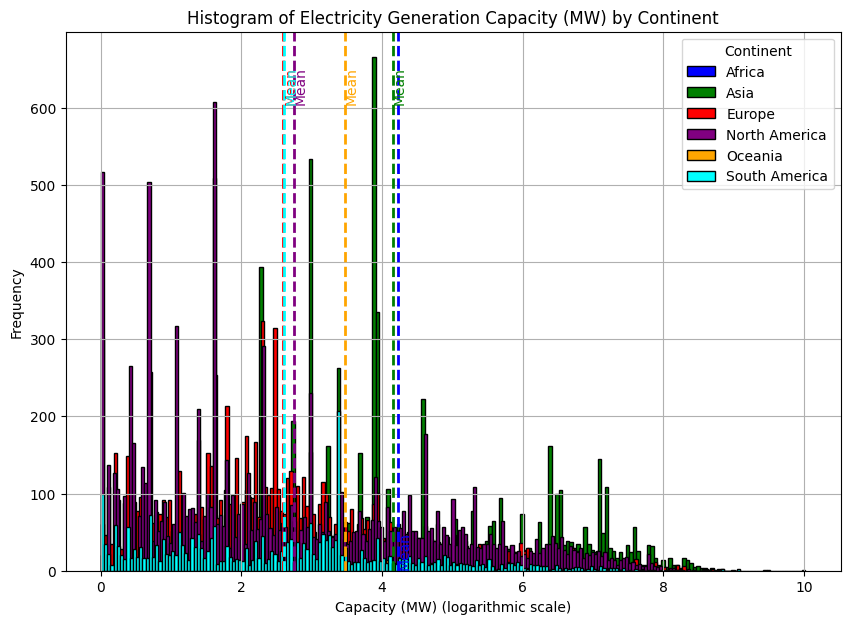

[1.00e+00 7.00e+00 4.60e+01 2.25e+04]
capacity_type
Low (1MW-7MW)          11800
High (46MW-22500MW)    11645
Medium (7MW-46MW)      11491
Name: count, dtype: int64


In [8]:
group_by_cont = pp_db.groupby('continent')['capacity_mw']
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'brown']

for (continent, data), color in zip(group_by_cont, colors):
    plt.hist(np.log(data), bins=200, alpha=1, label=continent, color=color, edgecolor='black')
    # Calculate and plot the mean
    mean_value = np.log(data).mean()
    plt.axvline(mean_value, color=color, linestyle='dashed', linewidth=2)
    plt.text(mean_value, plt.ylim()[1]*0.9, 'Mean', color=color, rotation=90, verticalalignment='center')

# Add labels and legend
plt.title('Histogram of Electricity Generation Capacity (MW) by Continent')
plt.xlabel('Capacity (MW) (logarithmic scale)')
plt.ylabel('Frequency')
plt.legend(title='Continent')
plt.grid(True)

# Show the plot
plt.show()

pp_db['capacity_type'], bins = pd.qcut(pp_db['capacity_mw'], q=3, labels=['Low (1MW-7MW)', 'Medium (7MW-46MW)', 'High (46MW-22500MW)'], retbins=True)
print(bins)
print(pp_db['capacity_type'].value_counts())


In [9]:
pp_db['text'] = pp_db['name'] + ', ' + pp_db['country']

###### Create web app with Plotly/Dash #######

app = Dash(external_stylesheets=[dbc.themes.SLATE])

fuel_color_map = {
    # Renewable Energy Sources
    'Hydro': '#2ECC71',        # Light Green
    'Solar': '#F1C40F',        # Yellow
    'Wind': '#3498DB',         # Light Blue
    'Biomass': '#27AE60',      # Green
    'Wave and Tidal': '#1ABC9C',  # Teal
    'Geothermal': '#9B59B6',   # Purple

    # Non-Renewable Energy Sources
    'Nuclear': '#34495E',      # Dark Blue-Grey
    'Coal': '#E74C3C',         # Red
    'Gas': '#E67E22',          # Dark Orange
    'Oil': '#D35400',          # Darker Orange
    'Petcoke': '#95A5A6',      # Grey

    # Other Categories
    'Other': '#BDC3C7',        # Light Grey
    'Waste': '#7F8C8D',        # Dark Grey
    'Cogeneration': '#16A085', # Dark Teal
    'Storage': '#2980B9',      # Blue

    # Category Labels (Overall)
    'Renewable': '#2ECC71',    # Light Green
    'Non-Renewable': '#E74C3C', # Red
}

custom_colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Green
    "#3357FF",  # Blue
    "#F39C12",  # Orange
    "#9B59B6",  # Purple
    "#E74C3C",  # Red
    "#1ABC9C",  # Teal
    "#8E44AD",  # Dark Purple
    "#3498DB",  # Light Blue
    "#2ECC71",  # Light Green
    "#E67E22",  # Dark Orange
    "#ECF0F1",  # Light Grey
    "#95A5A6",  # Grey
    "#34495E",  # Dark Blue-Grey
    "#16A085"   # Dark Teal
]

map_columns=['country_long', 'name', 'capacity_mw', 'primary_fuel', 'longitude', 'latitude', 'text']
map_df = pp_db.sort_values(by='capacity_mw', ascending=False).head(5000)[map_columns]
map_fig = px.scatter_geo(
    data_frame=map_df,
    lat='latitude',
    lon='longitude',
    color='primary_fuel',
    hover_name='text',
    color_discrete_sequence=custom_colors,
    size='capacity_mw',
    opacity=0.7,
    projection='natural earth',
    title='Global Distribution of High Capacity Power Plants'
)

# Update marker border properties
map_fig.update_traces(
    marker=dict(
        line=dict(
            color='black',  # Border color
            width=0.1  # Border width
        )
    )
)

app.layout =  html.Div([
    html.H1('Global Distribution of Power Plants', style={'textAlign': 'center', 'color': '#7FDBFF'}),
    html.Div(children='Explore trends in power plant capacity and energy source across continents', style={'textAlign':'center'}),
    dbc.Row([
                dbc.Col([html.Div("Largest Power Plants Table", style={'textAlign': 'center'}),
                         html.Br(),
                        dash_table.DataTable(data=pp_db[['country_long', 'name', 'capacity_mw', 'primary_fuel']].sort_values('capacity_mw', ascending=False).to_dict('records'), 
                         page_size=10,
                         style_cell={'textAlign': 'left'},
                         fill_width=False)], width=6),
                html.Br(),
                dbc.Col([html.Label('Select Continent'),
                        dcc.Dropdown(id='capacity_dropdown',
                        options=pp_db['continent'].unique(),
                        value='Europe'),
                        dcc.RadioItems(id='capacity_radioitems',
                        options=[{'label':'Linear', 'value':'capacity_mw'},
                                {'label':'Logarithmic', 'value':'log_capacity_mw'}],
                        value='log_capacity_mw'),
                        dcc.Graph(id='capacity_hist')], width=6),
            ], align='center'),
    html.Br(),
    dbc.Row([
                dbc.Col([html.Div("Map of Largest Power Plant", style={'textAlign': 'center'}),
                         html.Br(),
                         dcc.Graph(figure=map_fig)], width=6),
                dbc.Col([
                            dbc.Row([   html.Label('Select Continent'),
                                        dcc.Dropdown(id='pie_dropdown',
                                        #options=pp_db['continent'].unique(),
                                        options = [{'label': continent, 'value': continent} for continent in pp_db['continent'].unique()] + [{'label': 'World', 'value': 'All'}],
                                        value='Europe'),
                                        dcc.Graph(id='pie_chart_cap'),
                                        dcc.RadioItems(id='pie_radioitems',
                                        options=[{'label':'Primary Fuel', 'value':'primary_fuel'},
                                                {'label':'Renewables', 'value':'energy_rating'}],
                                        value='primary_fuel'),
                                    ]),
                            dbc.Row([
                                        dcc.Graph(id='pie_chart_count')
                                    ])
                            
                        ], width=6)
            ])
    ])


@app.callback(Output('capacity_hist', 'figure'),
              Input('cont_dropdown', 'value'),
              Input('capacity_radioitems', 'value'))
def sync_input_hist(cont_selection, scaled_capacity):
    continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    continent_filtered.loc[:,'log_capacity_mw'] = np.log(continent_filtered['capacity_mw'])
    fig = px.histogram(continent_filtered,  
                       x=scaled_capacity,
                       hover_name=scaled_capacity,
                       color='primary_fuel',
                       nbins=100)
    if scaled_capacity=='log_capacity_mw':
        fig.update_xaxes(range=[0, 10])
    fig.update_layout(barmode='overlay')
    return fig

@app.callback(Output('pie_chart_cap', 'figure'),
              Input('cont_dropdown', 'value'),
              Input('pie_radioitems', 'value'))
def sync_input_pie_chart_cap(cont_selection, fuel_or_renew):
    if cont_selection!='All':
        continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    else:
        continent_filtered = pp_db
    grouped_by_fuel = continent_filtered.groupby(fuel_or_renew)['capacity_mw'].sum().reset_index()
    fig = px.pie(grouped_by_fuel, 
                 values='capacity_mw',
                 names=fuel_or_renew, 
                 title='Fraction of power plant capacity by primary fuel type (MW)',
                 color=fuel_or_renew,
                 color_discrete_map=fuel_color_map )
    return fig

@app.callback(Output('pie_chart_count', 'figure'),
              Input('cont_dropdown', 'value'),
              Input('pie_radioitems', 'value'))
def sync_input_pie_chart_counts(cont_selection, fuel_or_renew):
    if cont_selection!='All':
        continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    else:
        continent_filtered = pp_db
    grouped_by_fuel = continent_filtered.groupby(fuel_or_renew).size().reset_index(name='count')
    fig = px.pie(grouped_by_fuel, 
                 values='count',
                 names=fuel_or_renew, 
                 title='Fraction of power plant counts by primary fuel type',
                 color=fuel_or_renew,
                 color_discrete_map=fuel_color_map)
    return fig


# Try keep the axes the same next time in between drop down options

app.run(jupyter_mode="external")
#app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash app running on http://127.0.0.1:8050/


In [10]:
continent_filtered = pp_db.loc[pp_db['continent']=='Europe'].copy()
#print(continent_filtered.groupby('primary_fuel')['capacity_mw'].sum().reset_index())
print(continent_filtered.groupby('primary_fuel').size().reset_index(name='count'))

      primary_fuel  count
0          Biomass    503
1             Coal    422
2     Cogeneration      7
3              Gas    779
4       Geothermal     46
5            Hydro   2056
6          Nuclear     74
7              Oil    125
8            Other     22
9            Solar   3921
10         Storage     31
11           Waste    443
12  Wave and Tidal      8
13            Wind   2329


In [23]:
pp_db['text'] = pp_db['name'] + ', ' + pp_db['country']

###### Create web app with Plotly/Dash #######

app = Dash(external_stylesheets=[dbc.themes.SLATE])

fuel_color_map = {
    # Renewable Energy Sources
    'Hydro': '#2ECC71',        # Light Green
    'Solar': '#F1C40F',        # Yellow
    'Wind': '#3498DB',         # Light Blue
    'Biomass': '#27AE60',      # Green
    'Wave and Tidal': '#1ABC9C',  # Teal
    'Geothermal': '#9B59B6',   # Purple

    # Non-Renewable Energy Sources
    'Nuclear': '#34495E',      # Dark Blue-Grey
    'Coal': '#E74C3C',         # Red
    'Gas': '#E67E22',          # Dark Orange
    'Oil': '#D35400',          # Darker Orange
    'Petcoke': '#95A5A6',      # Grey

    # Other Categories
    'Other': '#BDC3C7',        # Light Grey
    'Waste': '#7F8C8D',        # Dark Grey
    'Cogeneration': '#16A085', # Dark Teal
    'Storage': '#2980B9',      # Blue

    # Category Labels (Overall)
    'Renewable': '#2ECC71',    # Light Green
    'Non-Renewable': '#E74C3C', # Red
}

custom_colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Green
    "#3357FF",  # Blue
    "#F39C12",  # Orange
    "#9B59B6",  # Purple
    "#E74C3C",  # Red
    "#1ABC9C",  # Teal
    "#8E44AD",  # Dark Purple
    "#3498DB",  # Light Blue
    "#2ECC71",  # Light Green
    "#E67E22",  # Dark Orange
    "#ECF0F1",  # Light Grey
    "#95A5A6",  # Grey
    "#34495E",  # Dark Blue-Grey
    "#16A085"   # Dark Teal
]

map_columns=['country_long', 'name', 'capacity_mw', 'primary_fuel', 'longitude', 'latitude', 'text']
map_df = pp_db.sort_values(by='capacity_mw', ascending=False).head(5000)[map_columns]
map_fig = px.scatter_geo(
    data_frame=map_df,
    lat='latitude',
    lon='longitude',
    color='primary_fuel',
    hover_name='text',
    color_discrete_sequence=custom_colors,
    size='capacity_mw',
    opacity=0.7,
    projection='natural earth',
    title='Global Distribution of High Capacity Power Plants'
)

# Update marker border properties
map_fig.update_traces(
    marker=dict(
        line=dict(
            color='black',  # Border color
            width=0.1  # Border width
        )
    )
)

def drawTitle():
    return html.Div([
        dbc.Card(
            dbc.CardBody([
                html.Div([
                    html.H1("Dashboard for EDA of Global Power Plants Database"),
                ], style={'textAlign': 'center'}) 
            ])
        ),
    ])

def drawInstr():
    return html.Div([
        dbc.Card(
            dbc.CardBody([
                html.Div([
                    html.H3("Select Continent:"),
                ], style={'textAlign': 'center'}) 
            ])
        ),
    ])

def drawDropdown():
    return html.Div([
        dbc.Card(
            dbc.CardBody([
                html.Div([
                    html.H3("Select Continent:"),
                ], style={'textAlign': 'center'}),
                dcc.Dropdown(id='cont_dropdown',
                        options = [{'label': continent, 'value': continent} for continent in pp_db['continent'].unique()] + [{'label': 'World', 'value': 'All'}],
                        value='Europe'), 
            ])
        ),
    ])

def drawTable():
    return  html.Div([
        dbc.Card(
            dbc.CardBody([html.Div("Largest Power Plants Table", style={'textAlign': 'center'}),

                        dash_table.DataTable(data=pp_db[['country_long', 'name', 'capacity_mw', 'primary_fuel']].sort_values('capacity_mw', ascending=False).to_dict('records'), 
                         page_size=10,
                         style_cell={'textAlign': 'left'},
                         fill_width=False)
            ])
        ),  
    ])

def drawPieChart1():
    return  html.Div([
        dbc.Card(
            dbc.CardBody([dcc.RadioItems(id='pie_radioitems',
                        options=[{'label':'Primary Fuel', 'value':'primary_fuel'},
                                {'label':'Renewables', 'value':'renew_energy'}],
                        value='primary_fuel',
                        inline=True),
                        dcc.Graph(id='pie_chart_cap'),
            ])
        ),  
    ])

# def drawPieChart2():
#     return  html.Div([
#         dbc.Card(
#             dbc.CardBody([dcc.Graph(id='pie_chart_count')
#             ])
#         ),  
#     ])

def drawMap():
    return  html.Div([
        dbc.Card(
            dbc.CardBody([html.Div("Map of Largest Power Plant", style={'textAlign': 'center'}),
                         dcc.Graph(figure=map_fig)
            ])
        ),  
    ])

def drawHist():
    return  html.Div([
        dbc.Card(
            dbc.CardBody([dcc.RadioItems(id='capacity_radioitems',
                        options=[{'label':'Linear', 'value':'capacity_mw'},
                                {'label':'Logarithmic', 'value':'log_capacity_mw'}],
                        value='log_capacity_mw',
                        inline=True),
                        dcc.Graph(id='capacity_hist')
            ])
        ),  
    ])

app.layout = html.Div([
    dbc.Card(
        dbc.CardBody([
            dbc.Row([
                dbc.Col(drawTitle(), width=12),
            ], align='center'),
            html.Br(),
            dbc.Row([
                dbc.Col(drawDropdown(), width=12),
            ], align='center'),
            dbc.Row([
                dbc.Col([
                    drawHist() 
                ], width=7),
                dbc.Col([
                    drawPieChart1()
                ], width=5),
            ], align='center'), 
            dbc.Row([
                dbc.Col([
                    drawMap()
                ], width=7),
                dbc.Col([
                    drawTable()
                ], width=5),
            ], align='center'),      
        ]), color = 'dark'
    )
])



@app.callback(Output('capacity_hist', 'figure'),
              Input('cont_dropdown', 'value'),
              Input('capacity_radioitems', 'value'))
def sync_input_hist(cont_selection, scaled_capacity):
    if cont_selection!='All':
        continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    else:
        continent_filtered = pp_db
    continent_filtered.loc[:,'log_capacity_mw'] = np.log(continent_filtered['capacity_mw'])
    fig = px.histogram(continent_filtered,  
                       x=scaled_capacity,
                       hover_name=scaled_capacity,
                       color='primary_fuel',
                       nbins=100)
    if scaled_capacity=='log_capacity_mw':
        fig.update_xaxes(range=[0, 10])
    fig.update_layout(barmode='overlay')
    return fig

@app.callback(Output('pie_chart_cap', 'figure'),
              Input('cont_dropdown', 'value'),
              Input('pie_radioitems', 'value'))
def sync_input_pie_chart_cap(cont_selection, fuel_or_renew):
    if cont_selection!='All':
        continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    else:
        continent_filtered = pp_db
    grouped_by_fuel = continent_filtered.groupby(fuel_or_renew)['capacity_mw'].sum().reset_index()
    fig = px.pie(grouped_by_fuel, 
                 values='capacity_mw',
                 names=fuel_or_renew, 
                 title='Fraction of power plant capacity by primary fuel type (MW)',
                 color=fuel_or_renew,
                 color_discrete_map=fuel_color_map )
    return fig

@app.callback(Output('pie_chart_count', 'figure'),
              Input('cont_dropdown', 'value'),
              Input('pie_radioitems', 'value'))
def sync_input_pie_chart_counts(cont_selection, fuel_or_renew):
    if cont_selection!='All':
        continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    else:
        continent_filtered = pp_db
    grouped_by_fuel = continent_filtered.groupby(fuel_or_renew).size().reset_index(name='count')
    fig = px.pie(grouped_by_fuel, 
                 values='count',
                 names=fuel_or_renew, 
                 title='Fraction of power plant counts by primary fuel type',
                 color=fuel_or_renew,
                 color_discrete_map=fuel_color_map)
    return fig


# Try keep the axes the same next time in between drop down options

app.run(jupyter_mode="external")
#app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter


Dash app running on http://127.0.0.1:8050/
